# Chinese Yuan and Bitcoin price Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(13, 7))
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
import sklearn.preprocessing
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt

import wrangle
from pandas.plotting import register_matplotlib_converters


# <div class="alert alert-block alert-info"> <b>Acquire<b> </div>
    
### Steps:
    
> 1. Read the csv files into a dataframe
2. Gather info on dataframes to see what must be prepped

In [2]:
cny = pd.read_csv('USD_CNY.csv',sep=',', skipinitialspace=True)
cny.head()

,Date,Price,Open,High,Low,Change %
0,"Dec 04, 2020",6.5301,6.5431,6.5529,6.5268,-0.18%
1,"Dec 03, 2020",6.5418,6.5540,6.5664,6.5423,-0.31%
2,"Dec 02, 2020",6.5622,6.5639,6.5692,6.5519,-0.13%
3,"Dec 01, 2020",6.5705,6.5789,6.5875,6.5606,-0.08%
4,"Nov 30, 2020",6.5760,6.5768,6.5950,6.5708,0.03%


In [3]:
cny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1296 non-null   object 
 1   Price     1296 non-null   float64
 2   Open      1296 non-null   float64
 3   High      1296 non-null   float64
 4   Low       1296 non-null   float64
 5   Change %  1296 non-null   object 
dtypes: float64(4), object(2)
memory usage: 60.9+ KB


In [4]:
# as we read the the btc csv, we have to call 'thousands' as this will be neccessary for the minmax scaler.

btc = pd.read_csv('BTC_USD.csv',sep=',', skipinitialspace=True, thousands=',')
btc.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 06, 2020",19165.0,19157.0,19248.0,19015.6,2.72K,0.04%
1,"Dec 05, 2020",19157.0,18657.0,19157.0,18657.0,3.66K,2.68%
2,"Dec 04, 2020",18657.0,19452.0,19452.0,18657.0,8.65K,-4.06%
3,"Dec 03, 2020",19447.0,19241.0,19560.0,18999.4,5.25K,1.07%
4,"Dec 02, 2020",19241.0,18807.0,19275.0,18538.0,7.63K,2.31%


In [5]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1827 non-null   object 
 1   Price     1827 non-null   float64
 2   Open      1827 non-null   float64
 3   High      1827 non-null   float64
 4   Low       1827 non-null   float64
 5   Vol.      1827 non-null   object 
 6   Change %  1827 non-null   object 
dtypes: float64(4), object(3)
memory usage: 100.0+ KB


## Dataframe preparation Plans

> - Will drop unneccessary columns 
- There are more btc rows than found in the cny dataframe. 
- Dates will need to be changed to datetime
- columns are listed in reverse. Historical data will need to be changed to oldest from most recent.

# <div class="alert alert-block alert-info"> <b>Prepare<b> </div>

In [6]:
cny = wrangle.prep_cny(cny)

In [7]:
btc = wrangle.prep_btc(btc)

In [8]:
### Merging the dataframes together

df = pd.merge(left=btc, right=cny, left_on='Date', right_on='Date')


In [9]:
### Notice we now have an equal amount of rows. 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 1294
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1295 non-null   datetime64[ns]
 1   Price      1295 non-null   float64       
 2   cny_price  1295 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 40.5 KB


In [10]:
### Dropping 'Date' for the scaler

df.drop(columns = ['Date'], inplace = True)

In [11]:
### Flipping the columns to be oldest to most recent.

df = df.iloc[::-1]

In [12]:
scaler = sklearn.preprocessing.MinMaxScaler()

df_s = wrangle.scale_minmax(df)

In [13]:
df_s

,BTC,CNY
0,0.001956,0.152984
1,0.003203,0.162875
2,0.003094,0.174744
3,0.002897,0.185515
4,0.005040,0.204748
...,...,...
1290,1.000000,0.337400
1291,0.954520,0.331355
1292,0.976975,0.322233
1293,0.987634,0.299813


In [14]:
### Time to Split ###

train_size = int(len(df_s) * .5)
validate_size = int(len(df_s) * .3)
test_size = int(len(df_s) - train_size - validate_size)

validate_end_index = train_size + validate_size

In [15]:
train = df_s[: train_size]
validate = df_s[train_size:validate_end_index]
test = df_s[validate_end_index:]
train

,BTC,CNY
0,0.001956,0.152984
1,0.003203,0.162875
2,0.003094,0.174744
3,0.002897,0.185515
4,0.005040,0.204748
...,...,...
642,0.373455,0.120123
643,0.367313,0.134960
644,0.348681,0.143203
645,0.367417,0.163315


In [16]:
validate_end_index

1035

# <div class="alert alert-block alert-info"> <b>Exploration<b> </div>

In [17]:
btc_c = btc.drop(columns = ['Date'])
btc_c = btc_c.iloc[::-1]

In [18]:
cny_c = cny.drop(columns = ['Date'])
cny_c = cny_c.iloc[::-1]

Text(0, 0.5, 'Price')

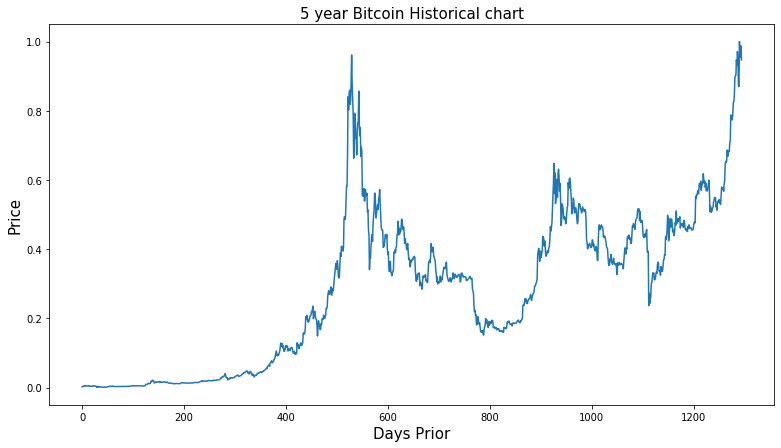

In [19]:
plt.plot(df_s.BTC)
plt.title(f"5 year Bitcoin Historical chart", size=15)
plt.xlabel('Days Prior', size=15)
plt.ylabel('Price', size=15)
#plt.style.use('fivethirtyeight')

Text(0, 0.5, 'Price')

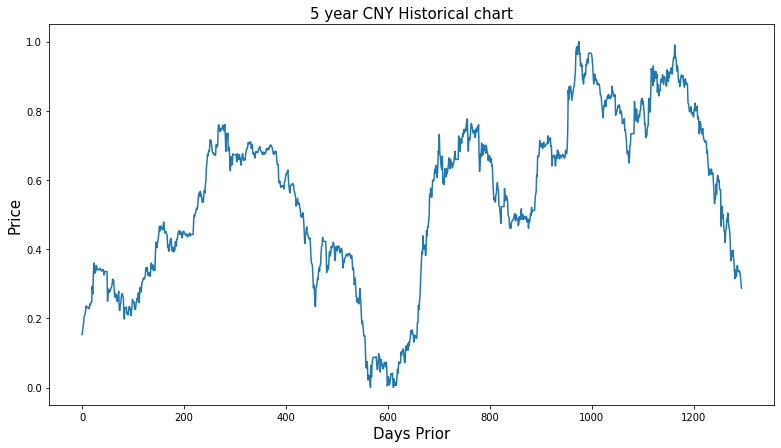

In [20]:
plt.plot(df_s.CNY)
plt.title(f"5 year CNY Historical chart", size=15)
plt.xlabel('Days Prior', size=15)
plt.ylabel('Price', size=15)
#plt.style.use('fivethirtyeight')

Text(0, 0.5, 'Scaled Price')

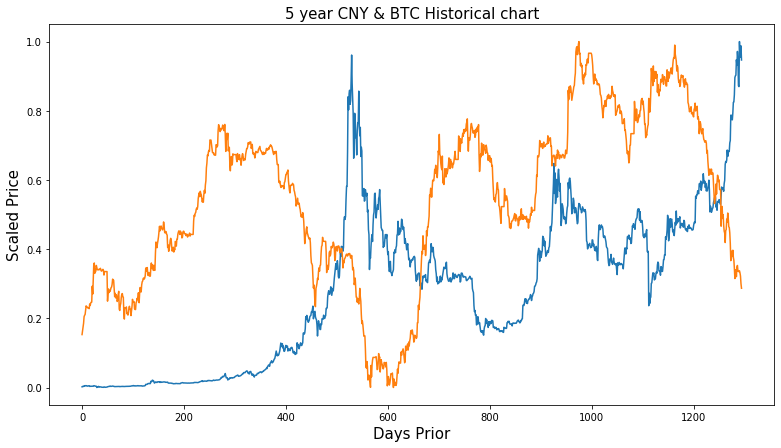

In [21]:
plt.plot(df_s)
plt.title(f"5 year CNY & BTC Historical chart", size=15)
plt.xlabel('Days Prior', size=15)
plt.ylabel('Scaled Price', size=15)
#plt.style.use('fivethirtyeight')

## Hypothesis Testing - Is there a relationship with CNY and BTC?

 $H_o$ - There is no relationship with the Chinese Yuan and Bitcoin

 $H_a$ - There is a relationship with the Chinese Yuan and Bitcoin

 $a = .05$

In [22]:
r, p = stats.pearsonr(df_s.BTC, df_s.CNY)
print('r = ',r)
print('p = ',p,'\n')

print('Conclusion: We reject the null hypothesis that there is no relationship between the Chinese Yuan and Bitcoin.')

r =  0.12533282411841334
p =  6.075823617519498e-06 

Conclusion: We reject the null hypothesis that there is no relationship between the Chinese Yuan and Bitcoin.


# <div class="alert alert-block alert-info"> <b>Modeling<b> </div>

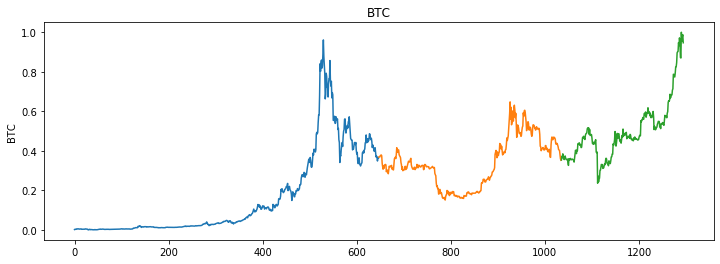

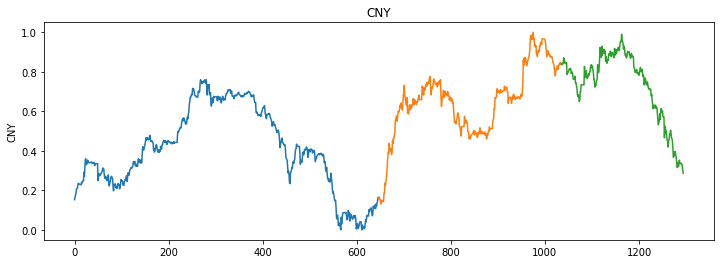

In [23]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### Baseline - Last observed Value

In [24]:
btc_baseline = .363024

In [25]:
cny_baseline = .164853

In [26]:
yhat_df = pd.DataFrame({'btc_lov': [btc_baseline], 
                        'cny_lov': [cny_baseline]}, 
                      index = validate.index)

yhat_df.head()

rmse_btc = round(sqrt(mean_squared_error(validate['BTC'], yhat_df['btc_lov'])), 2)
rmse_cny = round(sqrt(mean_squared_error(validate['CNY'], yhat_df['cny_lov'])), 2)

BTC RMSE: 0.12


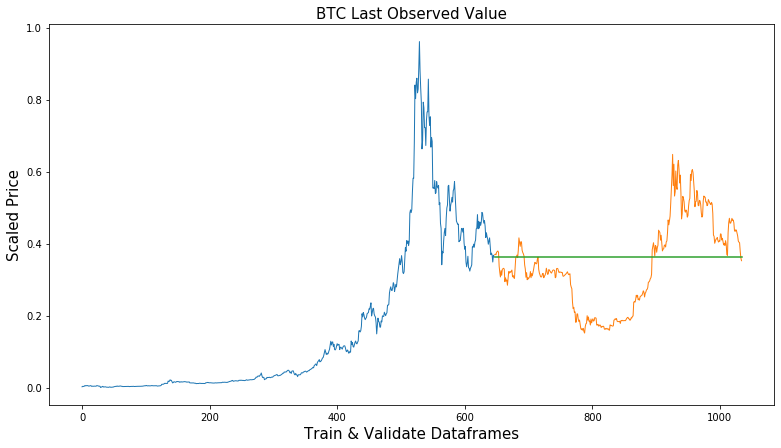

In [27]:
plt.plot(train['BTC'], label='Train', linewidth=1)
plt.plot(validate['BTC'], label='Validate', linewidth=1)
plt.plot(yhat_df['btc_lov'])
plt.title(f"BTC Last Observed Value", size=15)
plt.xlabel('Train & Validate Dataframes', size=15)
plt.ylabel('Scaled Price', size=15)
print('BTC RMSE:', rmse_btc)

CNY RMSE: 0.52


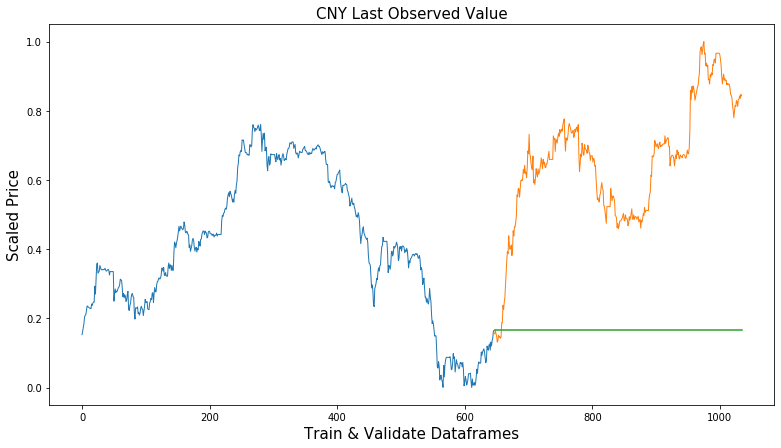

In [28]:
plt.plot(train['CNY'], label='Train', linewidth=1)
plt.plot(validate['CNY'], label='Validate', linewidth=1)
plt.plot(yhat_df['cny_lov'])
plt.title(f"CNY Last Observed Value", size=15)
plt.xlabel('Train & Validate Dataframes', size=15)
plt.ylabel('Scaled Price', size=15)
print('CNY RMSE:', rmse_cny)

### Simple Average

In [29]:
btc_price = round(train['BTC'].mean(), 2)
cny_price = round(train['CNY'].mean(), 2)


yhat_df = pd.DataFrame({'btc': [btc_price],
                        'cny': [cny_price],
                        }, index = validate.index)


rmse_btc = round(sqrt(mean_squared_error(validate['BTC'], yhat_df['btc'])), 2)
rmse_cny = round(sqrt(mean_squared_error(validate['CNY'], yhat_df['cny'])), 2)

In [30]:
yhat_df.head()

,btc,cny
647,0.16,0.4
648,0.16,0.4
649,0.16,0.4
650,0.16,0.4
651,0.16,0.4


BTC RMSE: 0.22


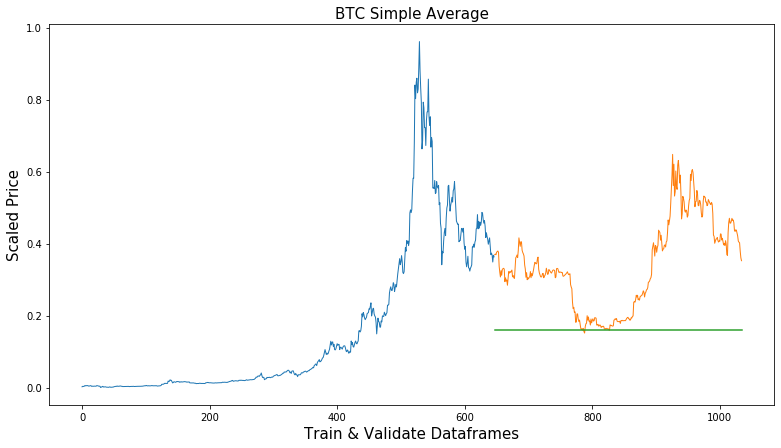

In [31]:
plt.plot(train['BTC'], label='Train', linewidth=1)
plt.plot(validate['BTC'], label='Validate', linewidth=1)
plt.plot(yhat_df['btc'])
plt.title(f"BTC Simple Average", size=15)
plt.xlabel('Train & Validate Dataframes', size=15)
plt.ylabel('Scaled Price', size=15)
print('BTC RMSE:', rmse_btc)

CNY RMSE: 0.31


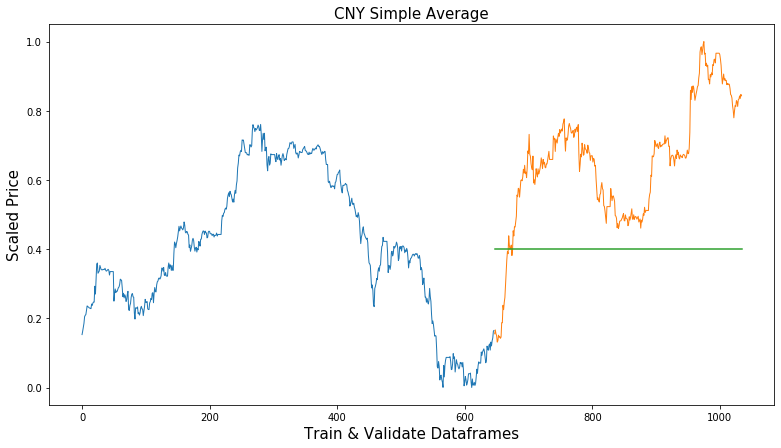

In [32]:
plt.plot(train['CNY'], label='Train', linewidth=1)
plt.plot(validate['CNY'], label='Validate', linewidth=1)
plt.plot(yhat_df['cny'])
plt.title(f"CNY Simple Average", size=15)
plt.xlabel('Train & Validate Dataframes', size=15)
plt.ylabel('Scaled Price', size=15)
print('CNY RMSE:', rmse_cny)

### Moving Average

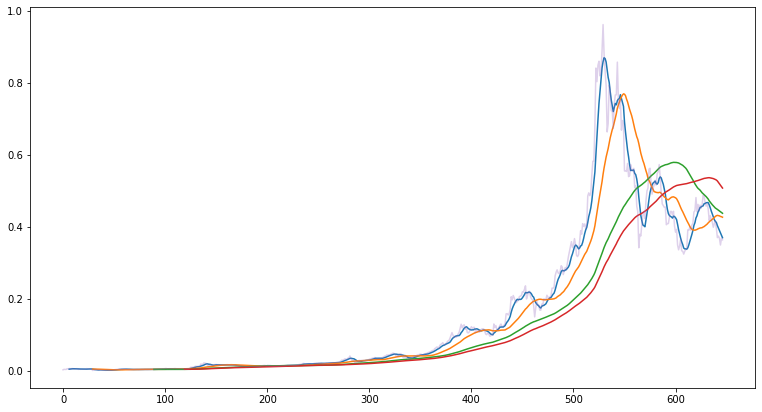

In [33]:
plt.plot(train['BTC'].rolling(7).mean())
plt.plot(train['BTC'].rolling(30).mean())
plt.plot(train['BTC'].rolling(90).mean())
plt.plot(train['BTC'].rolling(120).mean())
plt.plot(train['BTC'], alpha=.3)


In [34]:
period = 7

cny_price_ma = round(train['CNY'].rolling(period).mean().iloc[-1], 2)
btc_price_ma = round(train['BTC'].rolling(period).mean().iloc[-1], 2)

In [35]:

yhat_df = pd.DataFrame({'btc': [btc_price_ma],
                        'cny': [cny_price_ma],
                        }, index = validate.index)


rmse_btc = round(sqrt(mean_squared_error(validate['BTC'], yhat_df['btc'])), 2)
rmse_cny = round(sqrt(mean_squared_error(validate['CNY'], yhat_df['cny'])), 2)

yhat_df.head()

,btc,cny
647,0.37,0.14
648,0.37,0.14
649,0.37,0.14
650,0.37,0.14
651,0.37,0.14


BTC RMSE: 0.13


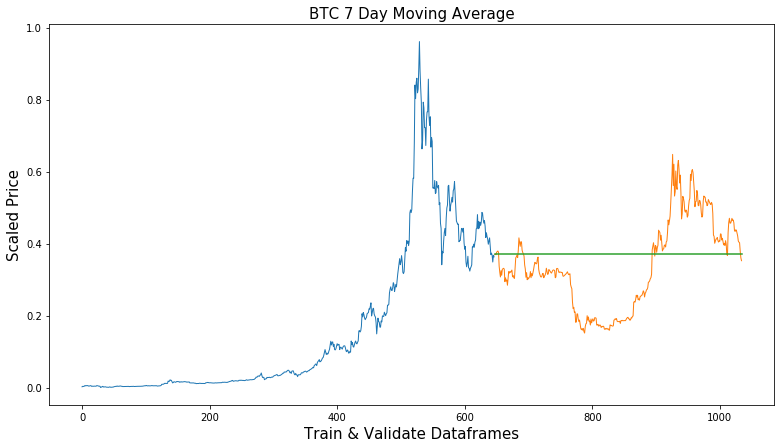

In [36]:
plt.plot(train['BTC'], label='Train', linewidth=1)
plt.plot(validate['BTC'], label='Validate', linewidth=1)
plt.plot(yhat_df['btc'])
plt.title(f"BTC 7 Day Moving Average", size=15)
plt.xlabel('Train & Validate Dataframes', size=15)
plt.ylabel('Scaled Price', size=15)
print('BTC RMSE:', rmse_btc)

CNY RMSE: 0.54


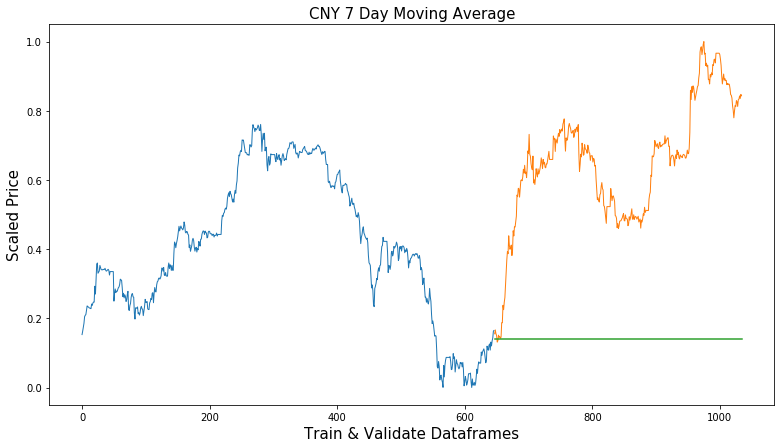

In [37]:
plt.plot(train['CNY'], label='Train', linewidth=1)
plt.plot(validate['CNY'], label='Validate', linewidth=1)
plt.plot(yhat_df['cny'])
plt.title(f"CNY 7 Day Moving Average", size=15)
plt.xlabel('Train & Validate Dataframes', size=15)
plt.ylabel('Scaled Price', size=15)
print('CNY RMSE:', rmse_cny)

In [38]:
period = 90

cny_price_ma = round(train['CNY'].rolling(period).mean().iloc[-1], 2)
btc_price_ma = round(train['BTC'].rolling(period).mean().iloc[-1], 2)


yhat_df = pd.DataFrame({'btc': [btc_price_ma],
                        'cny': [cny_price_ma],
                        }, index = validate.index)
    

rmse_btc = round(sqrt(mean_squared_error(validate['BTC'], yhat_df['btc'])), 2)
rmse_cny = round(sqrt(mean_squared_error(validate['CNY'], yhat_df['cny'])), 2)

yhat_df.head()

,btc,cny
647,0.44,0.07
648,0.44,0.07
649,0.44,0.07
650,0.44,0.07
651,0.44,0.07


BTC RMSE: 0.16


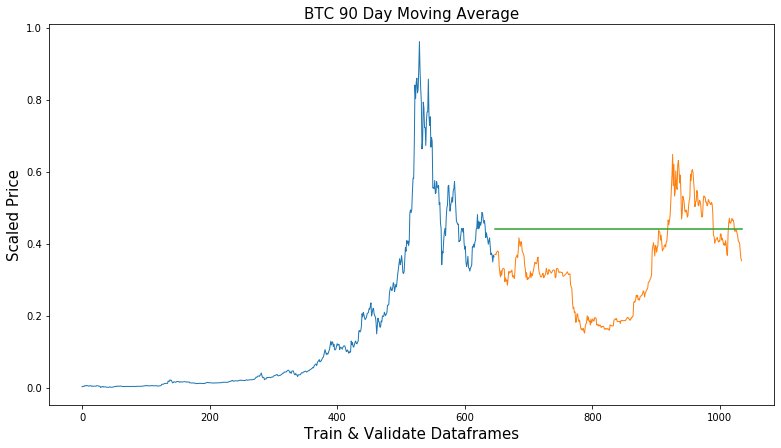

In [39]:
plt.plot(train['BTC'], label='Train', linewidth=1)
plt.plot(validate['BTC'], label='Validate', linewidth=1)
plt.plot(yhat_df['btc'])
plt.title(f"BTC 90 Day Moving Average", size=15)
plt.xlabel('Train & Validate Dataframes', size=15)
plt.ylabel('Scaled Price', size=15)
print('BTC RMSE:', rmse_btc)

CNY RMSE: 0.61


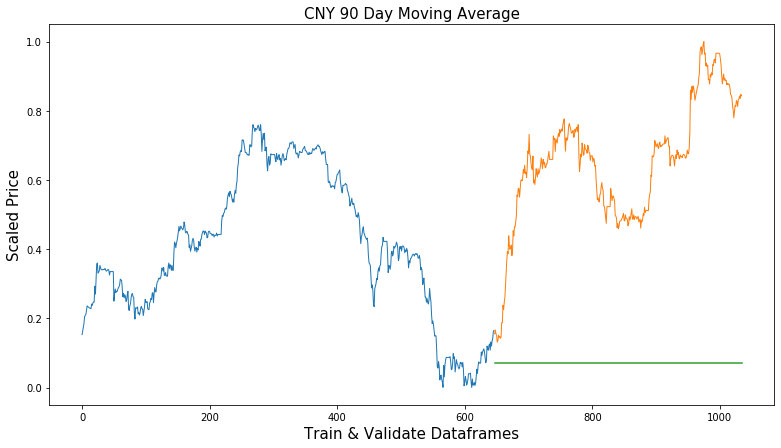

In [40]:
plt.plot(train['CNY'], label='Train', linewidth=1)
plt.plot(validate['CNY'], label='Validate', linewidth=1)
plt.plot(yhat_df['cny'])
plt.title(f"CNY 90 Day Moving Average", size=15)
plt.xlabel('Train & Validate Dataframes', size=15)
plt.ylabel('Scaled Price', size=15)
print('CNY RMSE:', rmse_cny)

## FB Prophet

In [41]:
### bringing in fresh csv's
cny = pd.read_csv('USD_CNY.csv',sep=',', skipinitialspace=True)
cny.head()

cny.drop(columns = ['Open',
                  'High',
                  'Low',
                   'Change %'], inplace = True)

cny.rename(columns={'Date':'ds','Price':'y'}, inplace=True)

cny.ds = pd.to_datetime(cny.ds)

In [42]:
cny = cny.iloc[::-1]

In [43]:
# Resplitting due to model needing ds and y columns

train_size = int(len(cny) * .5)
validate_size = int(len(cny) * .3)
test_size = int(len(cny) - train_size - validate_size)

validate_end_index = train_size + validate_size

In [44]:
train_cn = cny[: train_size]
validate_cn = cny[train_size:validate_end_index]
test_cn = cny[validate_end_index:]
train_cn

,ds,y
1295,2015-12-07,6.4082
1294,2015-12-08,6.4172
1293,2015-12-09,6.4280
1292,2015-12-10,6.4378
1291,2015-12-11,6.4553
...,...,...
652,2018-05-24,6.3783
651,2018-05-25,6.3918
650,2018-05-28,6.3993
649,2018-05-29,6.4176


In [45]:
m = Prophet()
m.fit(train_cn)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1008,2019-05-26
1009,2019-05-27
1010,2019-05-28
1011,2019-05-29
1012,2019-05-30


In [47]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1008,2019-05-26,6.284212,4.640472,7.865728
1009,2019-05-27,6.235958,4.595692,7.830289
1010,2019-05-28,6.236440,4.583659,7.831097
1011,2019-05-29,6.236527,4.576911,7.840561
1012,2019-05-30,6.236868,4.570607,7.845961


Text(63.0, 0.5, 'Price')

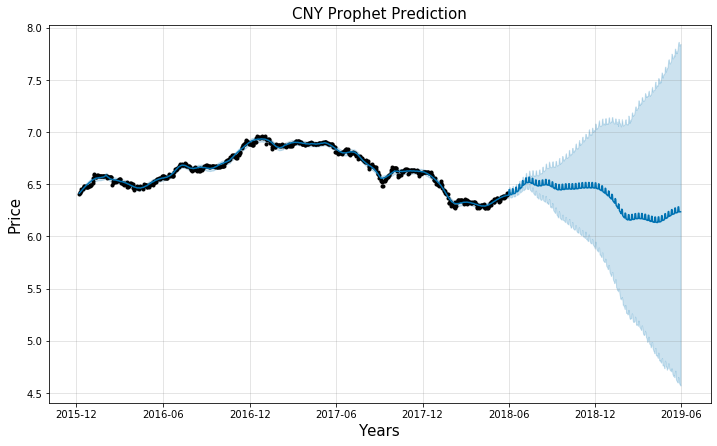

In [48]:
fig0 = m.plot(forecast)
plt.title(f"CNY Prophet Prediction", size=15)
plt.xlabel('Years', size=15)
plt.ylabel('Price', size=15)

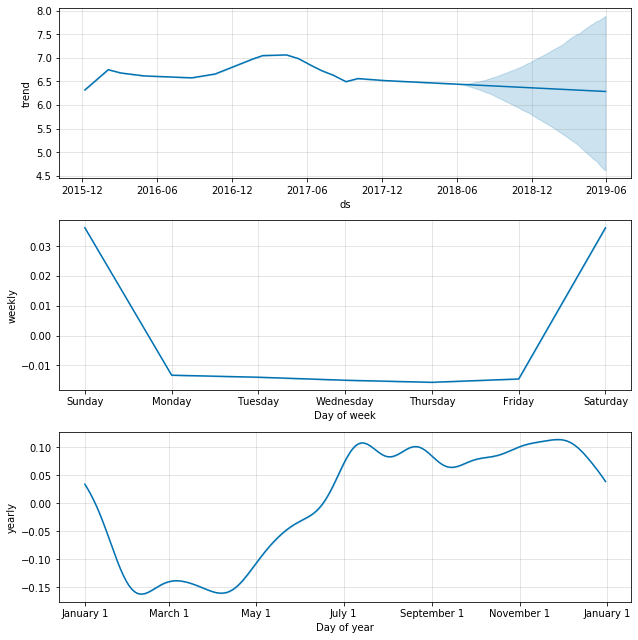

In [49]:
fig1 = m.plot_components(forecast)

In [50]:
btc = pd.read_csv('BTC_USD.csv',sep=',', skipinitialspace=True, thousands=',')

btc.drop(columns = ['Open',
                  'High',
                  'Low',
                    'Vol.',
                   'Change %'], inplace = True)

btc.Date = pd.to_datetime(btc.Date)
btc['Price'].astype(float)

btc.rename(columns={'Date':'ds','Price':'y'}, inplace=True)

btc = btc.iloc[::-1]

In [51]:
train_size = int(len(btc) * .5)
validate_size = int(len(btc) * .3)
test_size = int(len(btc) - train_size - validate_size)

validate_end_index = train_size + validate_size

In [52]:
train_ph = btc[: train_size]
validate_ph = btc[train_size:validate_end_index]
test_ph = btc[validate_end_index:]
train_ph

,ds,y
1826,2015-12-06,390.6
1825,2015-12-07,396.7
1824,2015-12-08,420.8
1823,2015-12-09,418.7
1822,2015-12-10,414.9
...,...,...
918,2018-06-02,7638.1
917,2018-06-03,7718.0
916,2018-06-04,7488.3
915,2018-06-05,7621.7


In [53]:
m0 = Prophet()
m0.fit(train_ph)

future0 = m0.make_future_dataframe(periods=365)
future0.tail()

forecast0 = m0.predict(future)
forecast0[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1008,2019-05-26,4969.069668,-5671.550259,15633.275972
1009,2019-05-27,4948.258643,-5423.581981,15726.156405
1010,2019-05-28,4918.260203,-5481.495999,15824.764147
1011,2019-05-29,4898.753662,-5519.734684,15831.709068
1012,2019-05-30,4893.037053,-5807.628450,16084.972122


Text(45.5, 0.5, 'Price')

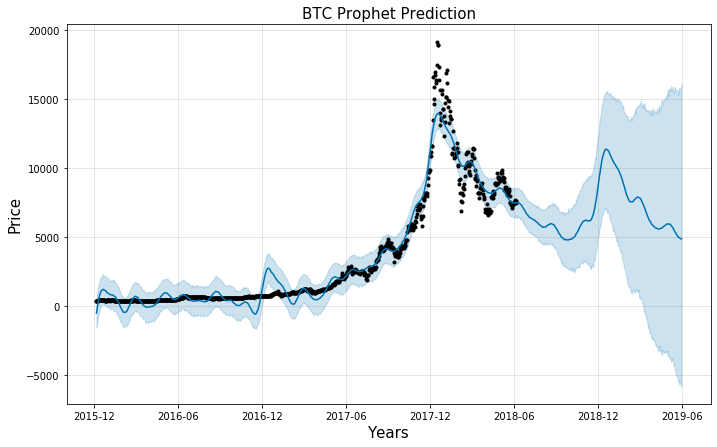

In [54]:
fig2 = m0.plot(forecast0)
plt.title(f"BTC Prophet Prediction", size=15)
plt.xlabel('Years', size=15)
plt.ylabel('Price', size=15)

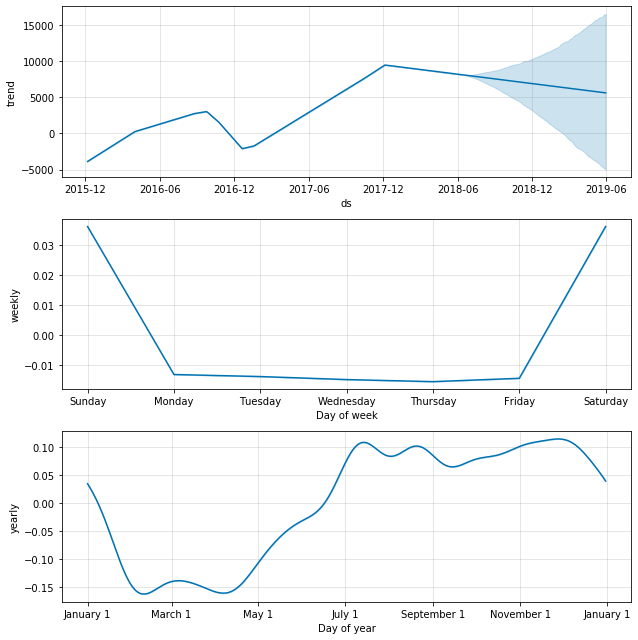

In [55]:
fig3 = m.plot_components(forecast0)

### Validate

### Simple Average

In [56]:
btc_price = round(validate['BTC'].mean(), 2)
cny_price = round(validate['CNY'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'btc': [btc_price],
                            'cny': [cny_price],
                           }, index = test.index)
    return yhat_df

yhat_df = make_predictions()

rmse_btc = round(sqrt(mean_squared_error(test['BTC'], yhat_df['btc'])), 2)
rmse_cny = round(sqrt(mean_squared_error(test['CNY'], yhat_df['cny'])), 2)

In [57]:
yhat_df.head()

,btc,cny
1035,0.34,0.65
1036,0.34,0.65
1037,0.34,0.65
1038,0.34,0.65
1039,0.34,0.65


BTC RMSE: 0.22


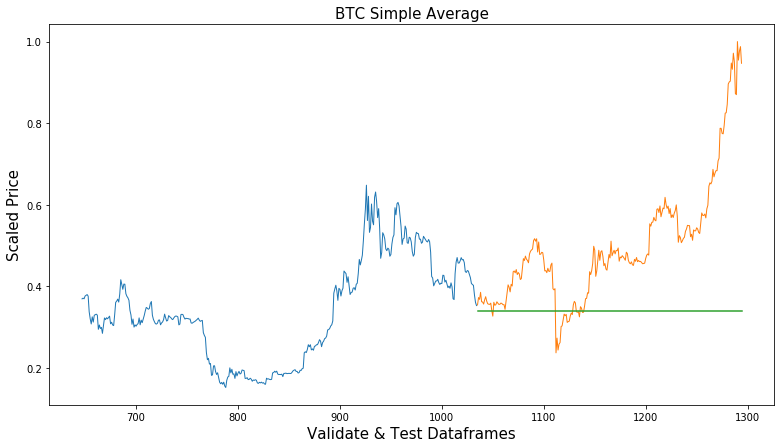

In [58]:
plt.plot(validate['BTC'], label='validate', linewidth=1)
plt.plot(test['BTC'], label='test', linewidth=1)
plt.plot(yhat_df['btc'])
plt.title(f"BTC Simple Average", size=15)
plt.xlabel('Validate & Test Dataframes', size=15)
plt.ylabel('Scaled Price', size=15)
print('BTC RMSE:', rmse_btc)

CNY RMSE: 0.19


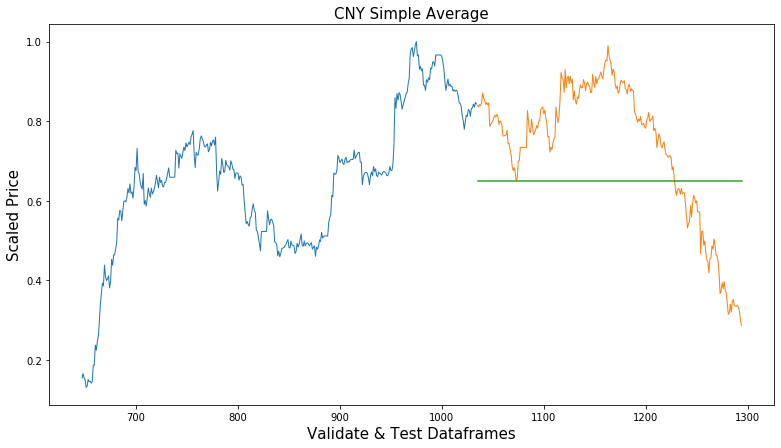

In [59]:
plt.plot(validate['CNY'], label='Validate', linewidth=1)
plt.plot(test['CNY'], label='Test', linewidth=1)
plt.plot(yhat_df['cny'])
plt.title(f"CNY Simple Average", size=15)
plt.xlabel('Validate & Test Dataframes', size=15)
plt.ylabel('Scaled Price', size=15)
print('CNY RMSE:', rmse_cny)

### FB Prophet

In [60]:
m = Prophet()
m.fit(validate_cn)

future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
748,2020-11-20,6.955293,3.208083,10.341180
749,2020-11-21,6.981137,3.237726,10.355429
750,2020-11-22,6.980850,3.211606,10.371653
751,2020-11-23,6.957345,3.194271,10.369735
752,2020-11-24,6.955538,3.135222,10.380564


Text(66.375, 0.5, 'Price')

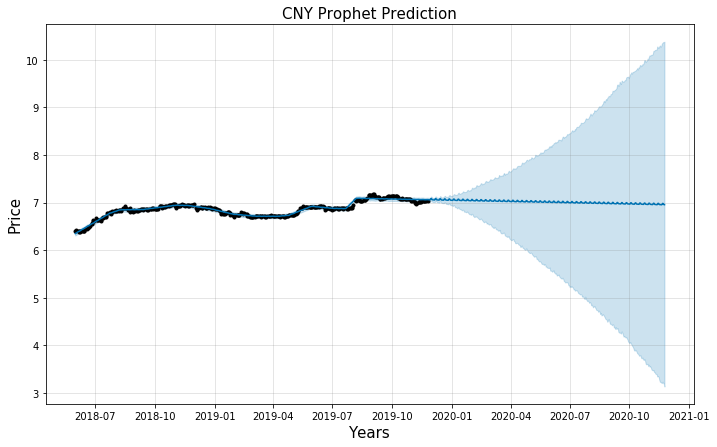

In [61]:
fig4 = m.plot(forecast)
plt.title(f"CNY Prophet Prediction", size=15)
plt.xlabel('Years', size=15)
plt.ylabel('Price', size=15)

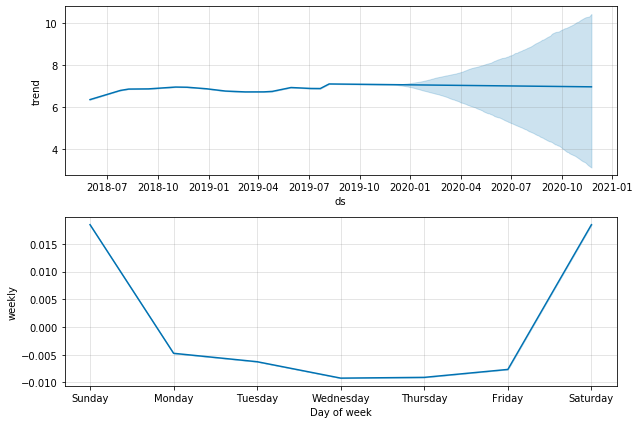

In [62]:
fig5 = m.plot_components(forecast)

In [63]:
m = Prophet()
m.fit(validate_ph)

future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
908,2020-12-01,-1254.972819,-14005.521996,11619.329405
909,2020-12-02,-1280.684920,-14154.273962,11673.427123
910,2020-12-03,-1352.686857,-14037.591098,11469.349160
911,2020-12-04,-1335.229273,-14384.659616,11758.894808
912,2020-12-05,-1352.595755,-14651.782087,11464.209052


Text(39.125, 0.5, 'Price')

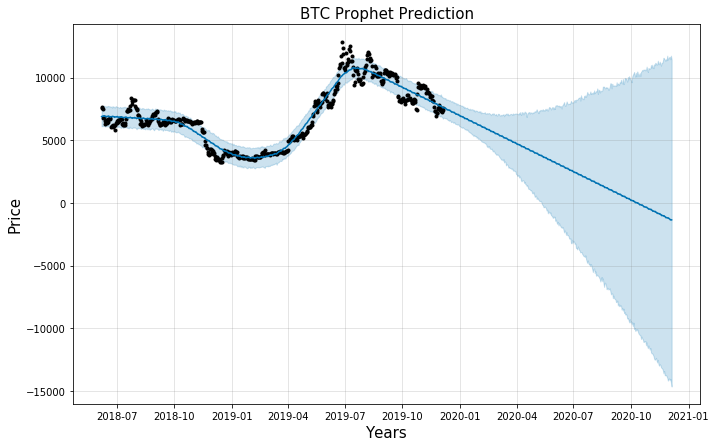

In [64]:
fig6 = m.plot(forecast)
plt.title(f"BTC Prophet Prediction", size=15)
plt.xlabel('Years', size=15)
plt.ylabel('Price', size=15)

### Test
> - To determine a correlation, the final model will utilize the FB Prophet Algorithym since it performed better than the other models.
- This will be done using the entire dataset since we are looking for a relationship between the two currencies.

In [65]:
m = Prophet()
m.fit(btc)

future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
2187,2021-12-02,21931.718225,11936.844807,33425.909350
2188,2021-12-03,21995.455929,11819.336479,33103.924759
2189,2021-12-04,22054.780190,11950.804086,33736.159324
2190,2021-12-05,22077.782349,11607.165595,33749.615247
2191,2021-12-06,22135.031408,11707.226321,33812.342209


Text(47.5, 0.5, 'Price')

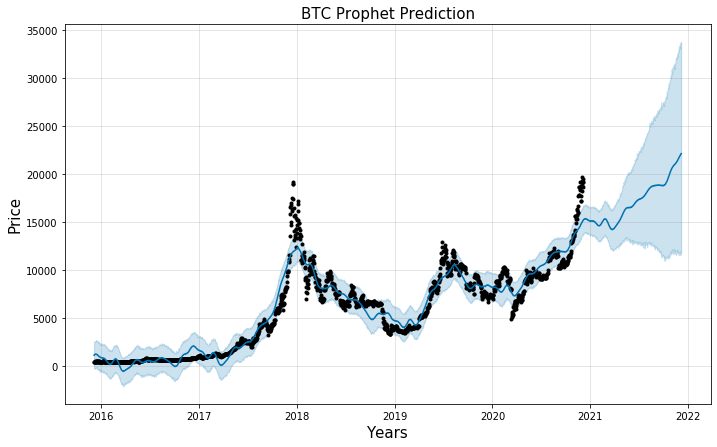

In [66]:
fig7 = m.plot(forecast)
plt.title(f"BTC Prophet Prediction", size=15)
plt.xlabel('Years', size=15)
plt.ylabel('Price', size=15)

In [67]:
m = Prophet()
m.fit(cny)

future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1656,2021-11-30,6.204494,3.951805,8.633369
1657,2021-12-01,6.202424,3.966578,8.649600
1658,2021-12-02,6.201164,3.956046,8.659735
1659,2021-12-03,6.200784,3.900605,8.705730
1660,2021-12-04,6.092663,3.776790,8.580192


Text(72.625, 0.5, 'Price')

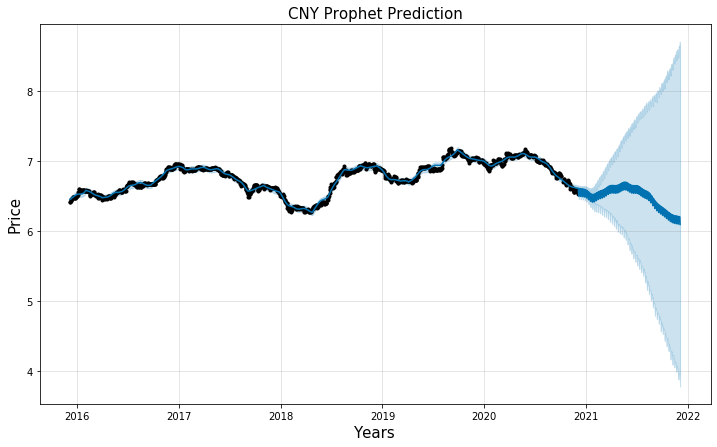

In [68]:
fig8 = m.plot(forecast)
plt.title(f"CNY Prophet Prediction", size=15)
plt.xlabel('Years', size=15)
plt.ylabel('Price', size=15)

# Takeaways

- Time Series models do not take into account for news, speculation, and sentiment.

- This is why the models were not able to predict any reversals that happened in the market. However, when a market is less volatile, the models are able to predict with less error.

- Finding or creating a model to account for major price reversals is something to look into. 

# Findings

- By rejecting our Null hypothesis that there is no relationship between the two currencies, we can visualize the findings to determine there is a slight inverted relationship ie: When BTC goes up, CNY goes down. 

- A relationship can also be verified through the Pearson Correlation test with a low P value meaning a relationship exists.